# Use VPG with Baseline to Play CartPole-v0

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
torch.manual_seed(0)

imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('CartPole-v0')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

22:54:08 [INFO] env: <CartPoleEnv<CartPole-v0>>
22:54:08 [INFO] action_space: Discrete(2)
22:54:08 [INFO] observation_space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
22:54:08 [INFO] reward_range: (-inf, inf)
22:54:08 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
22:54:08 [INFO] _max_episode_steps: 200
22:54:08 [INFO] _elapsed_steps: None


In [3]:
class VPGwBaselineAgent:
    def __init__(self, env,):
        self.action_n = env.action_space.n
        self.gamma = 0.99
        
        self.policy_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[],
                output_size=self.action_n, output_activator=nn.Softmax(1))
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=0.005)
        self.baseline_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[])
        self.baseline_optimizer = optim.Adam(self.policy_net.parameters(), lr=0.01)
        self.baseline_loss = nn.MSELoss()

    def build_net(self, input_size, hidden_sizes, output_size=1,
            output_activator=None, use_bias=False):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size, bias=use_bias))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        model = nn.Sequential(*layers)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
        prob_tensor = self.policy_net(state_tensor)
        action_tensor = distributions.Categorical(prob_tensor).sample()
        action = action_tensor.numpy()[0]
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
        return action

    def close(self):
        if self.mode == 'train':
            self.learn()

    def learn(self):
        state_tensor = torch.as_tensor(self.trajectory[0::4], dtype=torch.float)
        reward_tensor = torch.as_tensor(self.trajectory[1::4], dtype=torch.float)
        action_tensor = torch.as_tensor(self.trajectory[3::4], dtype=torch.long)
        arange_tensor = torch.arange(state_tensor.shape[0], dtype=torch.float)
        
        # train baseline
        discount_tensor = self.gamma ** arange_tensor
        discounted_reward_tensor = discount_tensor * reward_tensor
        discounted_return_tensor = discounted_reward_tensor.flip(0).cumsum(0).flip(0)
        return_tensor = discounted_return_tensor / discount_tensor
        pred_tensor = self.baseline_net(state_tensor)
        baseline_loss_tensor = self.baseline_loss(pred_tensor, return_tensor.unsqueeze(1))
        self.baseline_optimizer.zero_grad()
        baseline_loss_tensor.backward()
        self.baseline_optimizer.step()
        
        # train policy
        all_pi_tensor = self.policy_net(state_tensor)
        pi_tensor = torch.gather(all_pi_tensor, 1,
                action_tensor.unsqueeze(1)).squeeze(1)
        log_pi_tensor = torch.log(torch.clamp(pi_tensor, 1e-6, 1.))
        policy_loss_tensor = -(discounted_return_tensor * log_pi_tensor).mean()
        self.policy_optimizer.zero_grad()
        policy_loss_tensor.backward()
        self.policy_optimizer.step()


agent = VPGwBaselineAgent(env)

22:54:08 [INFO] ==== train ====
22:54:08 [DEBUG] train episode 0: reward = 21.00, steps = 21
22:54:08 [DEBUG] train episode 1: reward = 45.00, steps = 45
22:54:08 [DEBUG] train episode 2: reward = 17.00, steps = 17
22:54:08 [DEBUG] train episode 3: reward = 38.00, steps = 38
22:54:08 [DEBUG] train episode 4: reward = 28.00, steps = 28
22:54:09 [DEBUG] train episode 5: reward = 101.00, steps = 101
22:54:09 [DEBUG] train episode 6: reward = 10.00, steps = 10
22:54:09 [DEBUG] train episode 7: reward = 63.00, steps = 63
22:54:09 [DEBUG] train episode 8: reward = 39.00, steps = 39
22:54:09 [DEBUG] train episode 9: reward = 30.00, steps = 30
22:54:09 [DEBUG] train episode 10: reward = 77.00, steps = 77
22:54:09 [DEBUG] train episode 11: reward = 21.00, steps = 21
22:54:09 [DEBUG] train episode 12: reward = 17.00, steps = 17
22:54:09 [DEBUG] train episode 13: reward = 25.00, steps = 25
22:54:09 [DEBUG] train episode 14: reward = 40.00, steps = 40
22:54:09 [DEBUG] train episode 15: reward = 19

22:54:10 [DEBUG] train episode 132: reward = 42.00, steps = 42
22:54:10 [DEBUG] train episode 133: reward = 14.00, steps = 14
22:54:11 [DEBUG] train episode 134: reward = 33.00, steps = 33
22:54:11 [DEBUG] train episode 135: reward = 77.00, steps = 77
22:54:11 [DEBUG] train episode 136: reward = 22.00, steps = 22
22:54:11 [DEBUG] train episode 137: reward = 39.00, steps = 39
22:54:11 [DEBUG] train episode 138: reward = 36.00, steps = 36
22:54:11 [DEBUG] train episode 139: reward = 21.00, steps = 21
22:54:11 [DEBUG] train episode 140: reward = 53.00, steps = 53
22:54:11 [DEBUG] train episode 141: reward = 23.00, steps = 23
22:54:11 [DEBUG] train episode 142: reward = 53.00, steps = 53
22:54:11 [DEBUG] train episode 143: reward = 34.00, steps = 34
22:54:11 [DEBUG] train episode 144: reward = 14.00, steps = 14
22:54:11 [DEBUG] train episode 145: reward = 53.00, steps = 53
22:54:11 [DEBUG] train episode 146: reward = 72.00, steps = 72
22:54:11 [DEBUG] train episode 147: reward = 63.00, ste

22:54:13 [DEBUG] train episode 262: reward = 20.00, steps = 20
22:54:13 [DEBUG] train episode 263: reward = 55.00, steps = 55
22:54:13 [DEBUG] train episode 264: reward = 48.00, steps = 48
22:54:13 [DEBUG] train episode 265: reward = 105.00, steps = 105
22:54:13 [DEBUG] train episode 266: reward = 73.00, steps = 73
22:54:13 [DEBUG] train episode 267: reward = 66.00, steps = 66
22:54:13 [DEBUG] train episode 268: reward = 60.00, steps = 60
22:54:13 [DEBUG] train episode 269: reward = 27.00, steps = 27
22:54:13 [DEBUG] train episode 270: reward = 71.00, steps = 71
22:54:13 [DEBUG] train episode 271: reward = 46.00, steps = 46
22:54:13 [DEBUG] train episode 272: reward = 21.00, steps = 21
22:54:13 [DEBUG] train episode 273: reward = 27.00, steps = 27
22:54:13 [DEBUG] train episode 274: reward = 69.00, steps = 69
22:54:13 [DEBUG] train episode 275: reward = 22.00, steps = 22
22:54:13 [DEBUG] train episode 276: reward = 35.00, steps = 35
22:54:13 [DEBUG] train episode 277: reward = 25.00, s

22:54:16 [DEBUG] train episode 392: reward = 31.00, steps = 31
22:54:16 [DEBUG] train episode 393: reward = 29.00, steps = 29
22:54:16 [DEBUG] train episode 394: reward = 84.00, steps = 84
22:54:16 [DEBUG] train episode 395: reward = 109.00, steps = 109
22:54:16 [DEBUG] train episode 396: reward = 99.00, steps = 99
22:54:16 [DEBUG] train episode 397: reward = 49.00, steps = 49
22:54:16 [DEBUG] train episode 398: reward = 35.00, steps = 35
22:54:16 [DEBUG] train episode 399: reward = 49.00, steps = 49
22:54:16 [DEBUG] train episode 400: reward = 26.00, steps = 26
22:54:16 [DEBUG] train episode 401: reward = 68.00, steps = 68
22:54:16 [DEBUG] train episode 402: reward = 36.00, steps = 36
22:54:16 [DEBUG] train episode 403: reward = 49.00, steps = 49
22:54:16 [DEBUG] train episode 404: reward = 69.00, steps = 69
22:54:16 [DEBUG] train episode 405: reward = 22.00, steps = 22
22:54:16 [DEBUG] train episode 406: reward = 27.00, steps = 27
22:54:16 [DEBUG] train episode 407: reward = 78.00, s

22:54:20 [DEBUG] train episode 522: reward = 103.00, steps = 103
22:54:20 [DEBUG] train episode 523: reward = 105.00, steps = 105
22:54:21 [DEBUG] train episode 524: reward = 72.00, steps = 72
22:54:21 [DEBUG] train episode 525: reward = 25.00, steps = 25
22:54:21 [DEBUG] train episode 526: reward = 161.00, steps = 161
22:54:21 [DEBUG] train episode 527: reward = 96.00, steps = 96
22:54:21 [DEBUG] train episode 528: reward = 24.00, steps = 24
22:54:21 [DEBUG] train episode 529: reward = 68.00, steps = 68
22:54:21 [DEBUG] train episode 530: reward = 60.00, steps = 60
22:54:21 [DEBUG] train episode 531: reward = 134.00, steps = 134
22:54:21 [DEBUG] train episode 532: reward = 17.00, steps = 17
22:54:21 [DEBUG] train episode 533: reward = 149.00, steps = 149
22:54:21 [DEBUG] train episode 534: reward = 31.00, steps = 31
22:54:21 [DEBUG] train episode 535: reward = 109.00, steps = 109
22:54:21 [DEBUG] train episode 536: reward = 90.00, steps = 90
22:54:21 [DEBUG] train episode 537: reward 

22:54:26 [DEBUG] train episode 651: reward = 186.00, steps = 186
22:54:26 [DEBUG] train episode 652: reward = 200.00, steps = 200
22:54:26 [DEBUG] train episode 653: reward = 125.00, steps = 125
22:54:26 [DEBUG] train episode 654: reward = 200.00, steps = 200
22:54:26 [DEBUG] train episode 655: reward = 124.00, steps = 124
22:54:26 [DEBUG] train episode 656: reward = 200.00, steps = 200
22:54:26 [DEBUG] train episode 657: reward = 106.00, steps = 106
22:54:26 [DEBUG] train episode 658: reward = 38.00, steps = 38
22:54:26 [DEBUG] train episode 659: reward = 195.00, steps = 195
22:54:26 [DEBUG] train episode 660: reward = 90.00, steps = 90
22:54:26 [DEBUG] train episode 661: reward = 153.00, steps = 153
22:54:26 [DEBUG] train episode 662: reward = 93.00, steps = 93
22:54:26 [DEBUG] train episode 663: reward = 125.00, steps = 125
22:54:26 [DEBUG] train episode 664: reward = 115.00, steps = 115
22:54:26 [DEBUG] train episode 665: reward = 63.00, steps = 63
22:54:26 [DEBUG] train episode 66

22:54:31 [DEBUG] train episode 779: reward = 15.00, steps = 15
22:54:31 [DEBUG] train episode 780: reward = 129.00, steps = 129
22:54:31 [DEBUG] train episode 781: reward = 56.00, steps = 56
22:54:31 [DEBUG] train episode 782: reward = 199.00, steps = 199
22:54:31 [DEBUG] train episode 783: reward = 200.00, steps = 200
22:54:31 [DEBUG] train episode 784: reward = 190.00, steps = 190
22:54:31 [DEBUG] train episode 785: reward = 20.00, steps = 20
22:54:31 [DEBUG] train episode 786: reward = 200.00, steps = 200
22:54:31 [DEBUG] train episode 787: reward = 200.00, steps = 200
22:54:31 [DEBUG] train episode 788: reward = 114.00, steps = 114
22:54:31 [DEBUG] train episode 789: reward = 114.00, steps = 114
22:54:31 [DEBUG] train episode 790: reward = 130.00, steps = 130
22:54:31 [DEBUG] train episode 791: reward = 98.00, steps = 98
22:54:31 [DEBUG] train episode 792: reward = 72.00, steps = 72
22:54:31 [DEBUG] train episode 793: reward = 145.00, steps = 145
22:54:31 [DEBUG] train episode 794:

22:54:37 [DEBUG] train episode 907: reward = 200.00, steps = 200
22:54:37 [DEBUG] train episode 908: reward = 44.00, steps = 44
22:54:37 [DEBUG] train episode 909: reward = 46.00, steps = 46
22:54:37 [DEBUG] train episode 910: reward = 161.00, steps = 161
22:54:37 [DEBUG] train episode 911: reward = 119.00, steps = 119
22:54:37 [DEBUG] train episode 912: reward = 200.00, steps = 200
22:54:37 [DEBUG] train episode 913: reward = 121.00, steps = 121
22:54:37 [DEBUG] train episode 914: reward = 200.00, steps = 200
22:54:37 [DEBUG] train episode 915: reward = 123.00, steps = 123
22:54:37 [DEBUG] train episode 916: reward = 47.00, steps = 47
22:54:37 [DEBUG] train episode 917: reward = 200.00, steps = 200
22:54:37 [DEBUG] train episode 918: reward = 18.00, steps = 18
22:54:38 [DEBUG] train episode 919: reward = 54.00, steps = 54
22:54:38 [DEBUG] train episode 920: reward = 129.00, steps = 129
22:54:38 [DEBUG] train episode 921: reward = 200.00, steps = 200
22:54:38 [DEBUG] train episode 922:

22:54:44 [DEBUG] train episode 1034: reward = 123.00, steps = 123
22:54:44 [DEBUG] train episode 1035: reward = 200.00, steps = 200
22:54:44 [DEBUG] train episode 1036: reward = 166.00, steps = 166
22:54:45 [DEBUG] train episode 1037: reward = 198.00, steps = 198
22:54:45 [DEBUG] train episode 1038: reward = 153.00, steps = 153
22:54:45 [DEBUG] train episode 1039: reward = 195.00, steps = 195
22:54:45 [DEBUG] train episode 1040: reward = 194.00, steps = 194
22:54:45 [DEBUG] train episode 1041: reward = 18.00, steps = 18
22:54:45 [DEBUG] train episode 1042: reward = 175.00, steps = 175
22:54:45 [DEBUG] train episode 1043: reward = 111.00, steps = 111
22:54:45 [DEBUG] train episode 1044: reward = 37.00, steps = 37
22:54:45 [DEBUG] train episode 1045: reward = 123.00, steps = 123
22:54:45 [DEBUG] train episode 1046: reward = 156.00, steps = 156
22:54:45 [DEBUG] train episode 1047: reward = 88.00, steps = 88
22:54:45 [DEBUG] train episode 1048: reward = 200.00, steps = 200
22:54:45 [DEBUG]

22:54:53 [DEBUG] train episode 1159: reward = 200.00, steps = 200
22:54:53 [DEBUG] train episode 1160: reward = 200.00, steps = 200
22:54:53 [DEBUG] train episode 1161: reward = 174.00, steps = 174
22:54:53 [DEBUG] train episode 1162: reward = 163.00, steps = 163
22:54:53 [DEBUG] train episode 1163: reward = 200.00, steps = 200
22:54:53 [DEBUG] train episode 1164: reward = 96.00, steps = 96
22:54:53 [DEBUG] train episode 1165: reward = 200.00, steps = 200
22:54:53 [DEBUG] train episode 1166: reward = 200.00, steps = 200
22:54:53 [DEBUG] train episode 1167: reward = 200.00, steps = 200
22:54:53 [DEBUG] train episode 1168: reward = 199.00, steps = 199
22:54:53 [DEBUG] train episode 1169: reward = 200.00, steps = 200
22:54:54 [DEBUG] train episode 1170: reward = 200.00, steps = 200
22:54:54 [DEBUG] train episode 1171: reward = 200.00, steps = 200
22:54:54 [DEBUG] train episode 1172: reward = 73.00, steps = 73
22:54:54 [DEBUG] train episode 1173: reward = 159.00, steps = 159
22:54:54 [DEBU

22:55:02 [DEBUG] train episode 1284: reward = 200.00, steps = 200
22:55:02 [DEBUG] train episode 1285: reward = 141.00, steps = 141
22:55:02 [DEBUG] train episode 1286: reward = 109.00, steps = 109
22:55:02 [DEBUG] train episode 1287: reward = 200.00, steps = 200
22:55:02 [DEBUG] train episode 1288: reward = 164.00, steps = 164
22:55:02 [DEBUG] train episode 1289: reward = 162.00, steps = 162
22:55:02 [DEBUG] train episode 1290: reward = 163.00, steps = 163
22:55:02 [DEBUG] train episode 1291: reward = 200.00, steps = 200
22:55:02 [DEBUG] train episode 1292: reward = 22.00, steps = 22
22:55:02 [DEBUG] train episode 1293: reward = 200.00, steps = 200
22:55:02 [DEBUG] train episode 1294: reward = 64.00, steps = 64
22:55:02 [DEBUG] train episode 1295: reward = 40.00, steps = 40
22:55:03 [DEBUG] train episode 1296: reward = 200.00, steps = 200
22:55:03 [DEBUG] train episode 1297: reward = 163.00, steps = 163
22:55:03 [DEBUG] train episode 1298: reward = 200.00, steps = 200
22:55:03 [DEBUG]

22:55:12 [DEBUG] train episode 1409: reward = 155.00, steps = 155
22:55:12 [DEBUG] train episode 1410: reward = 200.00, steps = 200
22:55:12 [DEBUG] train episode 1411: reward = 200.00, steps = 200
22:55:12 [DEBUG] train episode 1412: reward = 200.00, steps = 200
22:55:12 [DEBUG] train episode 1413: reward = 200.00, steps = 200
22:55:12 [DEBUG] train episode 1414: reward = 168.00, steps = 168
22:55:13 [DEBUG] train episode 1415: reward = 179.00, steps = 179
22:55:13 [DEBUG] train episode 1416: reward = 127.00, steps = 127
22:55:13 [DEBUG] train episode 1417: reward = 125.00, steps = 125
22:55:13 [DEBUG] train episode 1418: reward = 112.00, steps = 112
22:55:13 [DEBUG] train episode 1419: reward = 200.00, steps = 200
22:55:13 [DEBUG] train episode 1420: reward = 115.00, steps = 115
22:55:13 [DEBUG] train episode 1421: reward = 200.00, steps = 200
22:55:13 [DEBUG] train episode 1422: reward = 200.00, steps = 200
22:55:13 [DEBUG] train episode 1423: reward = 192.00, steps = 192
22:55:13 [

22:55:22 [DEBUG] train episode 1534: reward = 200.00, steps = 200
22:55:22 [DEBUG] train episode 1535: reward = 137.00, steps = 137
22:55:22 [DEBUG] train episode 1536: reward = 172.00, steps = 172
22:55:22 [DEBUG] train episode 1537: reward = 186.00, steps = 186
22:55:22 [DEBUG] train episode 1538: reward = 200.00, steps = 200
22:55:23 [DEBUG] train episode 1539: reward = 200.00, steps = 200
22:55:23 [DEBUG] train episode 1540: reward = 97.00, steps = 97
22:55:23 [DEBUG] train episode 1541: reward = 178.00, steps = 178
22:55:23 [DEBUG] train episode 1542: reward = 100.00, steps = 100
22:55:23 [DEBUG] train episode 1543: reward = 183.00, steps = 183
22:55:23 [DEBUG] train episode 1544: reward = 37.00, steps = 37
22:55:23 [DEBUG] train episode 1545: reward = 169.00, steps = 169
22:55:23 [DEBUG] train episode 1546: reward = 146.00, steps = 146
22:55:23 [DEBUG] train episode 1547: reward = 200.00, steps = 200
22:55:23 [DEBUG] train episode 1548: reward = 200.00, steps = 200
22:55:23 [DEBU

22:55:34 [DEBUG] train episode 1659: reward = 182.00, steps = 182
22:55:34 [DEBUG] train episode 1660: reward = 184.00, steps = 184
22:55:34 [DEBUG] train episode 1661: reward = 200.00, steps = 200
22:55:34 [DEBUG] train episode 1662: reward = 175.00, steps = 175
22:55:34 [DEBUG] train episode 1663: reward = 200.00, steps = 200
22:55:34 [DEBUG] train episode 1664: reward = 200.00, steps = 200
22:55:34 [DEBUG] train episode 1665: reward = 200.00, steps = 200
22:55:34 [DEBUG] train episode 1666: reward = 200.00, steps = 200
22:55:34 [DEBUG] train episode 1667: reward = 198.00, steps = 198
22:55:35 [DEBUG] train episode 1668: reward = 142.00, steps = 142
22:55:35 [DEBUG] train episode 1669: reward = 31.00, steps = 31
22:55:35 [DEBUG] train episode 1670: reward = 185.00, steps = 185
22:55:35 [DEBUG] train episode 1671: reward = 200.00, steps = 200
22:55:35 [DEBUG] train episode 1672: reward = 151.00, steps = 151
22:55:35 [DEBUG] train episode 1673: reward = 200.00, steps = 200
22:55:35 [DE

22:55:45 [DEBUG] train episode 1784: reward = 190.00, steps = 190
22:55:45 [DEBUG] train episode 1785: reward = 133.00, steps = 133
22:55:45 [DEBUG] train episode 1786: reward = 200.00, steps = 200
22:55:45 [DEBUG] train episode 1787: reward = 200.00, steps = 200
22:55:46 [DEBUG] train episode 1788: reward = 196.00, steps = 196
22:55:46 [DEBUG] train episode 1789: reward = 200.00, steps = 200
22:55:46 [DEBUG] train episode 1790: reward = 200.00, steps = 200
22:55:46 [DEBUG] train episode 1791: reward = 200.00, steps = 200
22:55:46 [DEBUG] train episode 1792: reward = 200.00, steps = 200
22:55:46 [DEBUG] train episode 1793: reward = 96.00, steps = 96
22:55:46 [DEBUG] train episode 1794: reward = 157.00, steps = 157
22:55:46 [DEBUG] train episode 1795: reward = 200.00, steps = 200
22:55:46 [DEBUG] train episode 1796: reward = 129.00, steps = 129
22:55:46 [DEBUG] train episode 1797: reward = 112.00, steps = 112
22:55:46 [DEBUG] train episode 1798: reward = 109.00, steps = 109
22:55:46 [DE

22:55:57 [DEBUG] train episode 1909: reward = 200.00, steps = 200
22:55:57 [DEBUG] train episode 1910: reward = 200.00, steps = 200
22:55:57 [DEBUG] train episode 1911: reward = 200.00, steps = 200
22:55:57 [DEBUG] train episode 1912: reward = 200.00, steps = 200
22:55:57 [DEBUG] train episode 1913: reward = 149.00, steps = 149
22:55:57 [DEBUG] train episode 1914: reward = 170.00, steps = 170
22:55:57 [DEBUG] train episode 1915: reward = 200.00, steps = 200
22:55:58 [DEBUG] train episode 1916: reward = 200.00, steps = 200
22:55:58 [DEBUG] train episode 1917: reward = 200.00, steps = 200
22:55:58 [DEBUG] train episode 1918: reward = 161.00, steps = 161
22:55:58 [DEBUG] train episode 1919: reward = 200.00, steps = 200
22:55:58 [DEBUG] train episode 1920: reward = 168.00, steps = 168
22:55:58 [DEBUG] train episode 1921: reward = 162.00, steps = 162
22:55:58 [DEBUG] train episode 1922: reward = 189.00, steps = 189
22:55:58 [DEBUG] train episode 1923: reward = 200.00, steps = 200
22:55:58 [

22:56:09 [DEBUG] train episode 2034: reward = 120.00, steps = 120
22:56:09 [DEBUG] train episode 2035: reward = 182.00, steps = 182
22:56:09 [DEBUG] train episode 2036: reward = 200.00, steps = 200
22:56:10 [DEBUG] train episode 2037: reward = 147.00, steps = 147
22:56:10 [DEBUG] train episode 2038: reward = 200.00, steps = 200
22:56:10 [DEBUG] train episode 2039: reward = 193.00, steps = 193
22:56:10 [DEBUG] train episode 2040: reward = 161.00, steps = 161
22:56:10 [DEBUG] train episode 2041: reward = 200.00, steps = 200
22:56:10 [DEBUG] train episode 2042: reward = 200.00, steps = 200
22:56:10 [DEBUG] train episode 2043: reward = 200.00, steps = 200
22:56:10 [DEBUG] train episode 2044: reward = 134.00, steps = 134
22:56:11 [DEBUG] train episode 2045: reward = 172.00, steps = 172
22:56:11 [DEBUG] train episode 2046: reward = 200.00, steps = 200
22:56:11 [DEBUG] train episode 2047: reward = 200.00, steps = 200
22:56:11 [DEBUG] train episode 2048: reward = 196.00, steps = 196
22:56:11 [

22:56:23 [DEBUG] train episode 2159: reward = 200.00, steps = 200
22:56:23 [DEBUG] train episode 2160: reward = 175.00, steps = 175
22:56:23 [DEBUG] train episode 2161: reward = 172.00, steps = 172
22:56:23 [DEBUG] train episode 2162: reward = 200.00, steps = 200
22:56:23 [DEBUG] train episode 2163: reward = 133.00, steps = 133
22:56:23 [DEBUG] train episode 2164: reward = 199.00, steps = 199
22:56:23 [DEBUG] train episode 2165: reward = 181.00, steps = 181
22:56:23 [DEBUG] train episode 2166: reward = 200.00, steps = 200
22:56:23 [DEBUG] train episode 2167: reward = 122.00, steps = 122
22:56:24 [DEBUG] train episode 2168: reward = 200.00, steps = 200
22:56:24 [DEBUG] train episode 2169: reward = 144.00, steps = 144
22:56:24 [DEBUG] train episode 2170: reward = 200.00, steps = 200
22:56:24 [DEBUG] train episode 2171: reward = 200.00, steps = 200
22:56:24 [DEBUG] train episode 2172: reward = 200.00, steps = 200
22:56:24 [DEBUG] train episode 2173: reward = 200.00, steps = 200
22:56:24 [

22:56:35 [DEBUG] train episode 2284: reward = 194.00, steps = 194
22:56:36 [DEBUG] train episode 2285: reward = 130.00, steps = 130
22:56:36 [DEBUG] train episode 2286: reward = 200.00, steps = 200
22:56:36 [DEBUG] train episode 2287: reward = 200.00, steps = 200
22:56:36 [DEBUG] train episode 2288: reward = 172.00, steps = 172
22:56:36 [DEBUG] train episode 2289: reward = 66.00, steps = 66
22:56:36 [DEBUG] train episode 2290: reward = 200.00, steps = 200
22:56:36 [DEBUG] train episode 2291: reward = 166.00, steps = 166
22:56:36 [DEBUG] train episode 2292: reward = 165.00, steps = 165
22:56:36 [DEBUG] train episode 2293: reward = 200.00, steps = 200
22:56:36 [DEBUG] train episode 2294: reward = 200.00, steps = 200
22:56:36 [DEBUG] train episode 2295: reward = 200.00, steps = 200
22:56:37 [DEBUG] train episode 2296: reward = 136.00, steps = 136
22:56:37 [DEBUG] train episode 2297: reward = 200.00, steps = 200
22:56:37 [DEBUG] train episode 2298: reward = 200.00, steps = 200
22:56:37 [DE

22:56:49 [DEBUG] train episode 2409: reward = 200.00, steps = 200
22:56:49 [DEBUG] train episode 2410: reward = 200.00, steps = 200
22:56:49 [DEBUG] train episode 2411: reward = 126.00, steps = 126
22:56:50 [DEBUG] train episode 2412: reward = 181.00, steps = 181
22:56:50 [DEBUG] train episode 2413: reward = 200.00, steps = 200
22:56:50 [DEBUG] train episode 2414: reward = 200.00, steps = 200
22:56:50 [DEBUG] train episode 2415: reward = 145.00, steps = 145
22:56:50 [DEBUG] train episode 2416: reward = 200.00, steps = 200
22:56:50 [DEBUG] train episode 2417: reward = 200.00, steps = 200
22:56:50 [DEBUG] train episode 2418: reward = 156.00, steps = 156
22:56:50 [DEBUG] train episode 2419: reward = 131.00, steps = 131
22:56:50 [DEBUG] train episode 2420: reward = 167.00, steps = 167
22:56:51 [DEBUG] train episode 2421: reward = 160.00, steps = 160
22:56:51 [DEBUG] train episode 2422: reward = 197.00, steps = 197
22:56:51 [DEBUG] train episode 2423: reward = 200.00, steps = 200
22:56:51 [

22:57:04 [DEBUG] train episode 2534: reward = 200.00, steps = 200
22:57:04 [DEBUG] train episode 2535: reward = 200.00, steps = 200
22:57:04 [DEBUG] train episode 2536: reward = 188.00, steps = 188
22:57:04 [DEBUG] train episode 2537: reward = 200.00, steps = 200
22:57:04 [DEBUG] train episode 2538: reward = 200.00, steps = 200
22:57:04 [DEBUG] train episode 2539: reward = 160.00, steps = 160
22:57:04 [DEBUG] train episode 2540: reward = 132.00, steps = 132
22:57:04 [DEBUG] train episode 2541: reward = 165.00, steps = 165
22:57:04 [DEBUG] train episode 2542: reward = 175.00, steps = 175
22:57:05 [DEBUG] train episode 2543: reward = 155.00, steps = 155
22:57:05 [DEBUG] train episode 2544: reward = 200.00, steps = 200
22:57:05 [DEBUG] train episode 2545: reward = 125.00, steps = 125
22:57:05 [DEBUG] train episode 2546: reward = 171.00, steps = 171
22:57:05 [DEBUG] train episode 2547: reward = 117.00, steps = 117
22:57:05 [DEBUG] train episode 2548: reward = 200.00, steps = 200
22:57:05 [

22:57:17 [DEBUG] train episode 2659: reward = 138.00, steps = 138
22:57:17 [DEBUG] train episode 2660: reward = 165.00, steps = 165
22:57:18 [DEBUG] train episode 2661: reward = 200.00, steps = 200
22:57:18 [DEBUG] train episode 2662: reward = 200.00, steps = 200
22:57:18 [DEBUG] train episode 2663: reward = 200.00, steps = 200
22:57:18 [DEBUG] train episode 2664: reward = 200.00, steps = 200
22:57:18 [DEBUG] train episode 2665: reward = 190.00, steps = 190
22:57:18 [DEBUG] train episode 2666: reward = 102.00, steps = 102
22:57:18 [DEBUG] train episode 2667: reward = 148.00, steps = 148
22:57:18 [DEBUG] train episode 2668: reward = 200.00, steps = 200
22:57:18 [DEBUG] train episode 2669: reward = 137.00, steps = 137
22:57:19 [DEBUG] train episode 2670: reward = 178.00, steps = 178
22:57:19 [DEBUG] train episode 2671: reward = 200.00, steps = 200
22:57:19 [DEBUG] train episode 2672: reward = 200.00, steps = 200
22:57:19 [DEBUG] train episode 2673: reward = 200.00, steps = 200
22:57:19 [

22:57:31 [DEBUG] train episode 2784: reward = 200.00, steps = 200
22:57:31 [DEBUG] train episode 2785: reward = 200.00, steps = 200
22:57:32 [DEBUG] train episode 2786: reward = 200.00, steps = 200
22:57:32 [DEBUG] train episode 2787: reward = 200.00, steps = 200
22:57:32 [DEBUG] train episode 2788: reward = 159.00, steps = 159
22:57:32 [DEBUG] train episode 2789: reward = 200.00, steps = 200
22:57:32 [DEBUG] train episode 2790: reward = 200.00, steps = 200
22:57:32 [DEBUG] train episode 2791: reward = 200.00, steps = 200
22:57:32 [DEBUG] train episode 2792: reward = 68.00, steps = 68
22:57:32 [DEBUG] train episode 2793: reward = 119.00, steps = 119
22:57:33 [DEBUG] train episode 2794: reward = 200.00, steps = 200
22:57:33 [DEBUG] train episode 2795: reward = 85.00, steps = 85
22:57:33 [DEBUG] train episode 2796: reward = 174.00, steps = 174
22:57:33 [DEBUG] train episode 2797: reward = 200.00, steps = 200
22:57:33 [DEBUG] train episode 2798: reward = 200.00, steps = 200
22:57:33 [DEBU

22:57:45 [DEBUG] train episode 2909: reward = 200.00, steps = 200
22:57:45 [DEBUG] train episode 2910: reward = 200.00, steps = 200
22:57:45 [DEBUG] train episode 2911: reward = 163.00, steps = 163
22:57:45 [DEBUG] train episode 2912: reward = 200.00, steps = 200
22:57:45 [DEBUG] train episode 2913: reward = 200.00, steps = 200
22:57:45 [DEBUG] train episode 2914: reward = 145.00, steps = 145
22:57:45 [DEBUG] train episode 2915: reward = 200.00, steps = 200
22:57:45 [DEBUG] train episode 2916: reward = 200.00, steps = 200
22:57:45 [DEBUG] train episode 2917: reward = 200.00, steps = 200
22:57:46 [DEBUG] train episode 2918: reward = 200.00, steps = 200
22:57:46 [DEBUG] train episode 2919: reward = 200.00, steps = 200
22:57:46 [DEBUG] train episode 2920: reward = 119.00, steps = 119
22:57:46 [DEBUG] train episode 2921: reward = 200.00, steps = 200
22:57:46 [DEBUG] train episode 2922: reward = 141.00, steps = 141
22:57:46 [DEBUG] train episode 2923: reward = 200.00, steps = 200
22:57:46 [

22:57:57 [DEBUG] train episode 3034: reward = 200.00, steps = 200
22:57:57 [DEBUG] train episode 3035: reward = 132.00, steps = 132
22:57:58 [DEBUG] train episode 3036: reward = 200.00, steps = 200
22:57:58 [DEBUG] train episode 3037: reward = 200.00, steps = 200
22:57:58 [DEBUG] train episode 3038: reward = 200.00, steps = 200
22:57:58 [DEBUG] train episode 3039: reward = 200.00, steps = 200
22:57:58 [DEBUG] train episode 3040: reward = 200.00, steps = 200
22:57:58 [DEBUG] train episode 3041: reward = 200.00, steps = 200
22:57:58 [DEBUG] train episode 3042: reward = 169.00, steps = 169
22:57:58 [DEBUG] train episode 3043: reward = 200.00, steps = 200
22:57:58 [DEBUG] train episode 3044: reward = 200.00, steps = 200
22:57:58 [DEBUG] train episode 3045: reward = 200.00, steps = 200
22:57:59 [DEBUG] train episode 3046: reward = 200.00, steps = 200
22:57:59 [DEBUG] train episode 3047: reward = 200.00, steps = 200
22:57:59 [DEBUG] train episode 3048: reward = 200.00, steps = 200
22:57:59 [

22:58:09 [DEBUG] test episode 61: reward = 159.00, steps = 159
22:58:09 [DEBUG] test episode 62: reward = 200.00, steps = 200
22:58:09 [DEBUG] test episode 63: reward = 200.00, steps = 200
22:58:09 [DEBUG] test episode 64: reward = 187.00, steps = 187
22:58:10 [DEBUG] test episode 65: reward = 134.00, steps = 134
22:58:10 [DEBUG] test episode 66: reward = 200.00, steps = 200
22:58:10 [DEBUG] test episode 67: reward = 200.00, steps = 200
22:58:10 [DEBUG] test episode 68: reward = 200.00, steps = 200
22:58:10 [DEBUG] test episode 69: reward = 200.00, steps = 200
22:58:10 [DEBUG] test episode 70: reward = 200.00, steps = 200
22:58:10 [DEBUG] test episode 71: reward = 149.00, steps = 149
22:58:10 [DEBUG] test episode 72: reward = 200.00, steps = 200
22:58:10 [DEBUG] test episode 73: reward = 152.00, steps = 152
22:58:10 [DEBUG] test episode 74: reward = 200.00, steps = 200
22:58:11 [DEBUG] test episode 75: reward = 200.00, steps = 200
22:58:11 [DEBUG] test episode 76: reward = 156.00, step

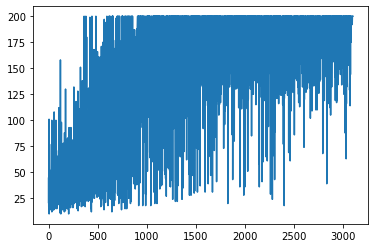

In [4]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    # episode_reward, elapsed_steps = play_episode(env, agent, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-20:]) > 199:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [5]:
env.close()